<a href="https://colab.research.google.com/github/firdowsacige/classification/blob/main/pspnet_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import required libraries
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Mount Google Drive (Optional, if saving models)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Download the Kvasir-SEG dataset
import wget
import zipfile

In [5]:
pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=f77e925aadeb90580546d29427612d965a74a5530690e9947279269ee0158eaa
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [7]:
url = "http://datasets.simula.no/downloads/kvasir-seg.zip"
zip_path = "kvasir-seg.zip"
wget.download(url, zip_path)


'kvasir-seg.zip'

In [8]:
# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/kvasir_seg")


In [9]:
IMG_DIR = "/content/kvasir_seg/Kvasir-SEG/images"
MASK_DIR = "/content/kvasir_seg/Kvasir-SEG/masks"

In [10]:
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, pool_sizes=(1, 2, 3, 6)):
        super(PyramidPoolingModule, self).__init__()
        self.pool_sizes = pool_sizes
        self.pools = nn.ModuleList([
            nn.AdaptiveAvgPool2d(output_size=pool_size) for pool_size in pool_sizes
        ])
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels, in_channels // len(pool_sizes), kernel_size=1, bias=False)
            for _ in pool_sizes
        ])

    def forward(self, x):
        h, w = x.shape[2], x.shape[3]
        pooled_features = [x]
        for pool, conv in zip(self.pools, self.convs):
            pooled = pool(x)
            pooled = conv(pooled)
            pooled = nn.functional.interpolate(pooled, size=(h, w), mode='bilinear', align_corners=False)
            pooled_features.append(pooled)
        return torch.cat(pooled_features, dim=1)


In [11]:
class PSPNet(nn.Module):
    def __init__(self, num_classes=1, backbone="resnet50"):
        super(PSPNet, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        in_channels = 2048
        self.ppm = PyramidPoolingModule(in_channels)
        self.final_conv = nn.Conv2d(in_channels * 2, 512, kernel_size=3, padding=1)
        self.upsample = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.ppm(x)
        x = self.final_conv(x)
        x = self.upsample(x)
        x = nn.functional.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)
        return x


In [12]:
class PolypDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        mask = (mask > 0).astype(np.uint8)  # Convert to binary mask

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"].unsqueeze(0)  # Add channel dimension

        return image, mask

# ---------------------- Define Transformations ----------------------
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# ---------------------- Set DataLoader ----------------------
batch_size = 4
dataset = PolypDataset(IMG_DIR, MASK_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ---------------------- Initialize Model, Loss, and Optimizer ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PSPNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 109MB/s]


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PSPNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------------- Training Loop ----------------------
epochs = 30  # Adjust as needed
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(dataloader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}")

print("Training complete!")

100%|██████████| 250/250 [00:28<00:00,  8.82it/s]


Epoch [1/30], Loss: 0.4830


100%|██████████| 250/250 [00:26<00:00,  9.55it/s]


Epoch [2/30], Loss: 0.3330


100%|██████████| 250/250 [00:26<00:00,  9.43it/s]


Epoch [3/30], Loss: 0.2955


100%|██████████| 250/250 [00:26<00:00,  9.47it/s]


Epoch [4/30], Loss: 0.2728


100%|██████████| 250/250 [00:26<00:00,  9.48it/s]


Epoch [5/30], Loss: 0.2681


100%|██████████| 250/250 [00:26<00:00,  9.49it/s]


Epoch [6/30], Loss: 0.2476


100%|██████████| 250/250 [00:26<00:00,  9.52it/s]


Epoch [7/30], Loss: 0.2405


100%|██████████| 250/250 [00:26<00:00,  9.40it/s]


Epoch [8/30], Loss: 0.2266


100%|██████████| 250/250 [00:26<00:00,  9.41it/s]


Epoch [9/30], Loss: 0.2244


100%|██████████| 250/250 [00:26<00:00,  9.48it/s]


Epoch [10/30], Loss: 0.2319


100%|██████████| 250/250 [00:26<00:00,  9.52it/s]


Epoch [11/30], Loss: 0.1998


100%|██████████| 250/250 [00:26<00:00,  9.49it/s]


Epoch [12/30], Loss: 0.1841


100%|██████████| 250/250 [00:26<00:00,  9.41it/s]


Epoch [13/30], Loss: 0.1740


100%|██████████| 250/250 [00:26<00:00,  9.42it/s]


Epoch [14/30], Loss: 0.1607


100%|██████████| 250/250 [00:26<00:00,  9.41it/s]


Epoch [15/30], Loss: 0.1704


100%|██████████| 250/250 [00:26<00:00,  9.43it/s]


Epoch [16/30], Loss: 0.1575


100%|██████████| 250/250 [00:26<00:00,  9.43it/s]


Epoch [17/30], Loss: 0.1556


100%|██████████| 250/250 [00:26<00:00,  9.40it/s]


Epoch [18/30], Loss: 0.1368


100%|██████████| 250/250 [00:26<00:00,  9.35it/s]


Epoch [19/30], Loss: 0.1923


100%|██████████| 250/250 [00:26<00:00,  9.49it/s]


Epoch [20/30], Loss: 0.1637


100%|██████████| 250/250 [00:26<00:00,  9.50it/s]


Epoch [21/30], Loss: 0.1341


100%|██████████| 250/250 [00:26<00:00,  9.48it/s]


Epoch [22/30], Loss: 0.1224


100%|██████████| 250/250 [00:26<00:00,  9.46it/s]


Epoch [23/30], Loss: 0.1186


100%|██████████| 250/250 [00:26<00:00,  9.46it/s]


Epoch [24/30], Loss: 0.1275


100%|██████████| 250/250 [00:26<00:00,  9.40it/s]


Epoch [25/30], Loss: 0.1293


100%|██████████| 250/250 [00:26<00:00,  9.42it/s]


Epoch [26/30], Loss: 0.1239


100%|██████████| 250/250 [00:26<00:00,  9.45it/s]


Epoch [27/30], Loss: 0.1032


100%|██████████| 250/250 [00:26<00:00,  9.45it/s]


Epoch [28/30], Loss: 0.1078


100%|██████████| 250/250 [00:26<00:00,  9.31it/s]


Epoch [29/30], Loss: 0.1046


100%|██████████| 250/250 [00:26<00:00,  9.45it/s]

Epoch [30/30], Loss: 0.1044
Training complete!


In [17]:
# ---------------------- Validation Loop ----------------------
model.eval()
with torch.no_grad():
    total_loss = 0.0
    for images, masks in tqdm(dataloader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks.float())
        total_loss += loss.item()

    print(f"Validation Loss: {total_loss/len(dataloader):.4f}")

print("Training and validation complete!")


100%|██████████| 250/250 [00:10<00:00, 22.92it/s]

Validation Loss: 0.0926
Training and validation complete!


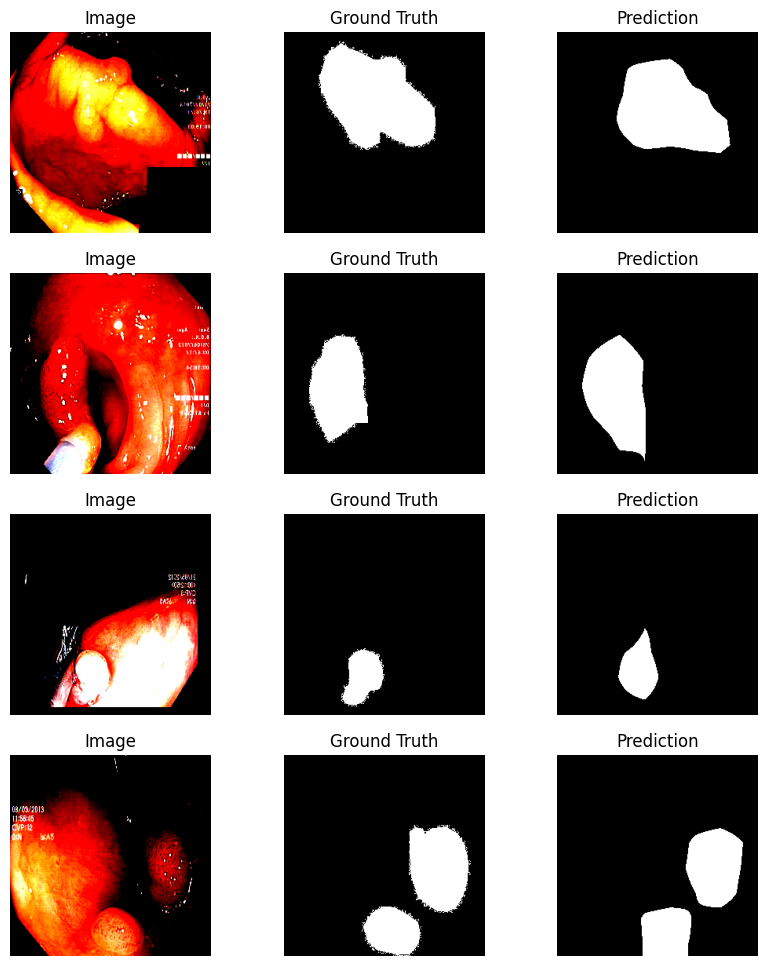

In [18]:
# ---------------------- Visualization Function ----------------------
def visualize_predictions(model, dataloader, device):
    model.eval()
    images, masks = next(iter(dataloader))
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        outputs = model(images)
        outputs = torch.sigmoid(outputs)  # Apply sigmoid activation
        outputs = (outputs > 0.5).float()  # Convert to binary mask

    fig, axes = plt.subplots(len(images), 3, figsize=(10, len(images) * 3))
    for i in range(len(images)):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        mask = masks[i].cpu().squeeze().numpy()
        pred = outputs[i].cpu().squeeze().numpy()

        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Image")
        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title("Ground Truth")
        axes[i, 2].imshow(pred, cmap="gray")
        axes[i, 2].set_title("Prediction")
        for ax in axes[i]:
            ax.axis("off")
    plt.show()

# Run prediction visualization
visualize_predictions(model, dataloader, device)


In [19]:
# ---------------------- Dice Score and IoU Calculation ----------------------
def dice_coefficient(pred, target, smooth=1e-6):
    """
    Compute Dice Score.
    pred and target should be binary masks (0 or 1).
    """
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()

def iou_coefficient(pred, target, smooth=1e-6):
    """
    Compute Intersection over Union (IoU).
    pred and target should be binary masks (0 or 1).
    """
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

# ---------------------- Compute Mean Dice and IoU ----------------------
def evaluate_model(model, dataloader, device):
    model.eval()
    total_dice = 0.0
    total_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs)  # Apply sigmoid activation
            preds = (outputs > 0.5).float()  # Convert to binary mask

            for i in range(images.shape[0]):  # Iterate over batch
                dice = dice_coefficient(preds[i], masks[i])
                iou = iou_coefficient(preds[i], masks[i])
                total_dice += dice
                total_iou += iou
                num_samples += 1

    mean_dice = total_dice / num_samples
    mean_iou = total_iou / num_samples
    print(f"Mean Dice Score: {mean_dice:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")

# Run evaluation
evaluate_model(model, dataloader, device)


100%|██████████| 250/250 [00:13<00:00, 19.14it/s]

Mean Dice Score: 0.8495
Mean IoU: 0.7565
